In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.sparse.linalg
import scipy.linalg
import linear_solvers

In this notebook, we will investigate the performance of the GMRES-E algorithm. This modification of the traditional GMRES method looks to augment the subspace in which we look for a solution by appending it with approximate eigenvectors.

**General Overview**

We start by first understanding why the GMRES-E algorithm helps convergence. It seems that the theory is built primarily around matrices that are close to normal. Note, for reference, a normal matrix satisfies the following:

$$
A^* \; A = A \; A^*
$$

In the case where $A$ is nearly normal (and has a spectral decomposition $A = Z \Lambda Z^{-1}$), and if the initial guess is the zero vector $x_0 = 0$, the residual convergence is given as

$$
\frac{||r||}{||b||} \leq 2 ||Z|| \; ||Z^{-1}|| \; \bigg( 1 - \frac{2}{\sqrt{\kappa} + 1} \bigg)^m
$$

where $\kappa$ is given as $\kappa = \frac{\lambda_n}{\lambda_1)}$. Note that as matrices get more non-normal, the convergence properties are more difficult to analyze (i.e., these bounds are nice and are only valid if the matrix is approximately normal).

We see that convergence is effectively dictated by the ratio of the eigenvalues and so, if we can reduce the spread in the values between the max and min eigenvalue, we can bring $\kappa$ closer to $1$ and in doing so the term in the RHS to the power of $m$ gets smaller. So, the goal will be to find a way to play with this expression in the convergence.

**Eigenvectors in Subspaces**

Now, we look to see that appending eigenvectors to the subspace to find the solution helps in convergence. If $k$ eigenvectors $\{z_k\}$ are added to a subspace to yield $<b, Ab, ..., A^{m-1}b, z_1, ..., z_k>$, then the convergence bounds from above change to 

$$
\frac{||r||}{||b||} \leq 2 ||Z|| \; ||Z^{-1}|| \; \bigg( 1 - \frac{2}{\sqrt{\kappa_e} + 1} \bigg)^m
$$

where now $\kappa_e = \frac{\lambda_n}{\lambda_{k+1}}$. Effectively, we have been able to remove the smaller eigenvalues that deteriorated convergence by appending their corresponding eigenvectors to the subspace. This result follows from the polynomial minimization bound RHS that we typically have for GMRES methods in the RHS. These polynomial bounds all start from representing the residual in the basis in which we are searching for the approximate solution (the Krylov space) and then rearranging to get bounds for the convergence of $||r_n||$. Now, say that we expand the RHS $b$ in terms of the eigenvectors, then it isn't hard to see that we get an expression for $r$ in terms of the eigenvectors plus a polynomial in the original Krylov space. Then we effectively see that we can bound the error convergence using only a polynomial along with the eigenvalues from $k+1$ to $n$ and so 


# GMRES-E Analysis
We start first by considering some test problems and looking at the behaviour of GMRES-E. We will look first at how well the eigenvectors are approximated in the approach as a function of restart iteration. We then will look at the convergence analysis relative to the traditional restarted GMRES where we will compare convergence using metrics such as residual drop vs. number of restart cycles.

## Case: Bidiagonal Matrix 1
Consider first the case of a LHS matrix which is bidiagonal. The matrix will be of dimension [1000, 1000] and has along its diagonal values [1, 2, ..., 1000]. Moreover, on the superdiagonal the matrix has the value 0.1. The eigenvalues of this upper-triangular matrix are simply the diagonal entries. 

We see that for this case since the matrix is approximately normal, the bounds above should hold. Therefore, for the standard GMRES case with $\kappa = 1000$ to give a RHS approximately equal to 

$$
RHS = 2 ||Z|| \; ||Z^{-1}|| \; \bigg( 1 - \frac{2}{31 + 1} \bigg)^m = 2 ||Z|| \; ||Z^{-1}|| \; \bigg( \frac{30}{32} \bigg)^m = 2 ||Z|| \; ||Z^{-1}|| \; \bigg( 0.9375 \bigg)^m
$$

which gives the approximate drop in the residual at each restart cycle (each restart cycle uses a Krylov space of dimension m).

Now, say that we are able to remove the first four eigenvalues $\kappa_e = \frac{1000}{5} = 200$. With this, the RHS for this case is given as

$$
RHS = 2 ||Z|| \; ||Z^{-1}|| \; \bigg( 1 - \frac{2}{14.14 + 1} \bigg)^m = 2 ||Z|| \; ||Z^{-1}|| \; \bigg( \frac{13.14}{15.14} \bigg)^m = 2 ||Z|| \; ||Z^{-1}|| \; (0.867)^m
$$

Looking through the math, we see that if the $\kappa$ value is increased by a factor of $l$, we expect to see (assuming $m$ is approximately the same still) a convergence rate that is $\sqrt{l}$ times faster (on a logarithmic plot). That is, on a logarithmic plot, the error should drop linearly with a slope that is $\sqrt{l}$ times steeper. 

We look to see whether this is indeed the case for this problem, which is a good testing ground as the number of eigenvectors that we choose to append to the space directly effects the $\kappa$ value since the eigenvalues are just the values from $1$ to $1000$ increasing by 1.


In [51]:

# Create the A matrix for the test case

#diag_vals_ex1 = np.array([0.2, 0.3, 0.4, 0.5])
#diag_vals_ex1 = np.append(diag_vals_ex1, np.linspace(10., 1000, 1000))

diag_vals_ex1 = np.linspace(1., 1000, 1000)
m = len(diag_vals_ex1)

A_ex1 = np.diag(diag_vals_ex1) + np.diag(np.ones(m-1)*0.1, 1)
print(A_ex1)


[[1.00e+00 1.00e-01 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 2.00e+00 1.00e-01 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 3.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 ...
 [0.00e+00 0.00e+00 0.00e+00 ... 9.98e+02 1.00e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 9.99e+02 1.00e-01]
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 0.00e+00 1.00e+03]]


In [52]:

# Create the b vector for the test case (should be a vector of all 1s)

b_ex1 = np.ones((A_ex1.shape[0], 1))


In [53]:

# Compute the standard GMRES solution
x0 = np.zeros(b_ex1.shape)
rst = 25

# The GMRES solve
(rel_res_convergence_gmres_ex1, x_n_gmres_ex1, data_dict_gmres_ex1) = \
     linear_solvers.GMRES(A_ex1, b_ex1, x0, rst, resid_relative_tolerance=1e-13)


Iter : 0,  Relative Residual Norm : 3.123154e-02
Iter : 25,  Relative Residual Norm : 8.288503e-13


In [73]:

# Compute the GMRES-E solution for various values of k (the number
# of eigenvectors to approximate)

k_vals = [4]
gmres_e_results_tuples = []

for k in k_vals:
    results_k_tuple = \
        linear_solvers.GMRES_E(A_ex1, b_ex1, x0, rst-k, k, resid_relative_tolerance=1e-13)
    
    gmres_e_results_tuples.append(results_k_tuple)



Iter : 0,  Relative Residual Norm : 3.920721e-02


### Visualize Residual Convergence
Plot the convergence in the relative residual as a function of restarts

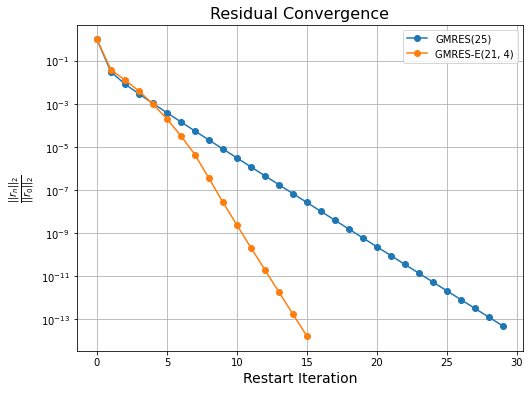

In [56]:

plt.figure(figsize=(8,6))

plt.semilogy(rel_res_convergence_gmres_ex1, marker='o', label="GMRES(%d)" % (rst))

for k_i in range(len(k_vals)):
    plt.semilogy(gmres_e_results_tuples[k_i][0], 
                 marker='o', label="GMRES-E(%d, %d)" % (rst-k_vals[k_i], k_vals[k_i]))

plt.xlabel("Restart Iteration", fontsize=14)
plt.ylabel(r"$\frac{||r_n||_2}{||r_0||_2}$", fontsize=14)

plt.title("Residual Convergence", fontsize=16)

plt.legend()

plt.grid()

#plt.savefig("Results/GMRES-E/resid_conv.pdf")


Residual Convergence Speed Up
k : 4, Rate Change: 2.504


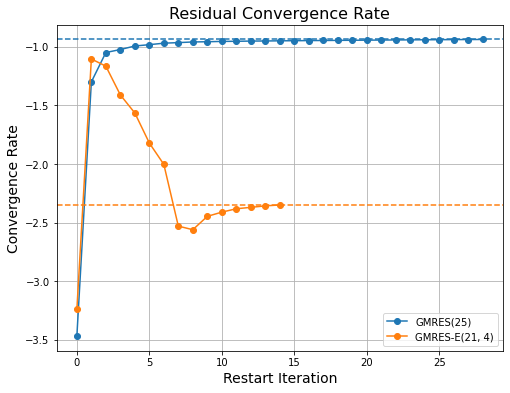

In [57]:

# Plot the convergence rate as a function of restart iteration for each approach.
# That is, we look to see the slope of the error convergence on the semi-log plot.

plt.figure(figsize=(8,6))

# GMRES
rel_res_conv_gmres_ex1_np = np.array(rel_res_convergence_gmres_ex1)
rel_res_conv_gmres_ex1_np_slopes = np.log(rel_res_conv_gmres_ex1_np[1:]) - np.log(rel_res_conv_gmres_ex1_np[:-1])

plt.plot(rel_res_conv_gmres_ex1_np_slopes, marker='o', label="GMRES(%d)" % (rst))
plt.axhline(rel_res_conv_gmres_ex1_np_slopes[-1], linestyle="--", c="C0")

# GMRES-E

rel_res_conv_gmres_e_ex1_np_slopes_k_vals = []
for k_i in range(len(k_vals)):
    
    rel_res_conv = gmres_e_results_tuples[k_i][0]
    rel_res_conv_np = np.array(rel_res_conv)
    rel_res_conv_np_slopes = np.log(rel_res_conv_np[1:]) - np.log(rel_res_conv_np[:-1])
    
    rel_res_conv_gmres_e_ex1_np_slopes_k_vals.append(rel_res_conv_np_slopes)
    
    plt.plot(rel_res_conv_np_slopes, marker='o', 
             label="GMRES-E(%d, %d)" % (rst - k_vals[k_i], k_vals[k_i]), c="C%d"%(k_i+1))
    plt.axhline(rel_res_conv_np_slopes[-1], linestyle="--", c="C%d"%(k_i+1))
    

plt.xlabel("Restart Iteration", fontsize=14)
plt.ylabel("Convergence Rate", fontsize=14)

plt.title("Residual Convergence Rate", fontsize=16)

plt.legend()

plt.grid()


# Print the speed up factors
print("Residual Convergence Speed Up")
for k_i in range(len(k_vals)):
    print("k : %d, Rate Change: %.3f" % (k_vals[k_i], 
            rel_res_conv_gmres_e_ex1_np_slopes_k_vals[k_i][-1]/rel_res_conv_gmres_ex1_np_slopes[-1]))

#plt.savefig("Results/GMRES-E/resid_conv_rate.pdf")
    

In [58]:

# Compute the l values for the case to see whether these values make sense

kappa_init = max(diag_vals_ex1)/min(diag_vals_ex1)

for k_i in range(len(k_vals)):
    lambda_max = max(diag_vals_ex1)
    lambda_min = diag_vals_ex1[k_vals[k_i]+1]
    
    kappa_i = lambda_max/lambda_min
    
    l_i = kappa_init/kappa_i
    print("k : %d, sqrt(l) : %.3f" % (k_vals[k_i], np.sqrt(l_i)))


k : 4, sqrt(l) : 2.449


In [59]:

# Check the eigenvalue convergence for the k = 4 case (first case)
k_val = k_vals[0]
eig_vals_conv = gmres_e_results_tuples[0][2]['eigenvals_convergence']

eig_vals_exact = diag_vals_ex1[0:k_val]

# Create a matrix of dimension [k x num_rst] to store the error in the 
# eigenvalues as a function of the restart value
eig_vals_conv_rel_err = np.zeros((k_val, len(eig_vals_conv)))

for i in range(len(eig_vals_conv)):
    # Loop over all the restart values
    
    for k in range(k_val):
        eig_rel_err = np.abs(eig_vals_conv[i][k] - eig_vals_exact[k])/np.abs(eig_vals_exact[k])
        eig_vals_conv_rel_err[k,i] = eig_rel_err


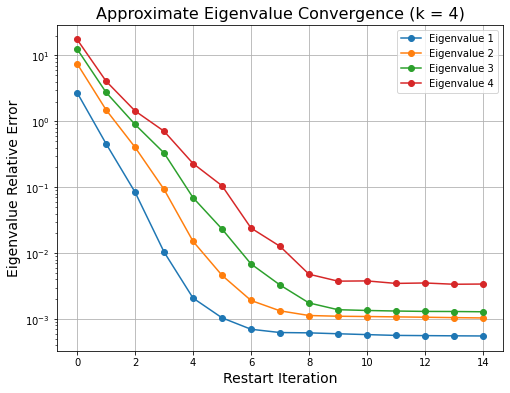

In [60]:

# Plot the error of the eigenvalue convergence

plt.figure(figsize=(8,6))

for i in range(k_val):
    # Loop over all the eigenvalues
    
    plt.semilogy(eig_vals_conv_rel_err[i,:], marker='o', label="Eigenvalue %d" % (i+1))

plt.xlabel("Restart Iteration", fontsize=14)
plt.ylabel("Eigenvalue Relative Error", fontsize=14)

plt.title("Approximate Eigenvalue Convergence (k = %d)" % (k_val), fontsize=16)

plt.legend()

plt.grid()

plt.savefig("Results/GMRES-E/eig_conv_k4.pdf")


In [65]:

# Get the exact eigenvectors 
[eig_vals_exact, eig_vecs_exact] = np.linalg.eig(A_ex1)


In [67]:

print(eig_vals_exact[0:4])
print(eig_vecs_exact.shape)


[1. 2. 3. 4.]
(1000, 1000)


In [83]:

# Check the eigenvector convergence for the k = 4 case
k_val = k_vals[0]
eig_vecs_conv = gmres_e_results_tuples[0][2]['eigenvecs_convergence']

eig_vecs_exact_subset = eig_vecs_exact[:,0:k_val]

# Create a matrix of dimension [k x num_rst] to store the error in the 
# eigenvectors as a function of the restart value
eig_vecs_conv_rel_err = np.zeros((k_val, len(eig_vecs_conv)))

for i in range(len(eig_vecs_conv)):
    # Loop over all the restart values
    
    for k in range(k_val):
        v_ik_approx = eig_vecs_conv[i][k]/np.linalg.norm(eig_vecs_conv[i][k])
        v_k_exact = eig_vecs_exact_subset[:,k]
        
        if np.dot(v_ik_approx, v_k_exact) < 0:
            v_ik_approx *= -1.0
        
        eig_vec_rel_err = np.linalg.norm(v_ik_approx - v_k_exact)/np.linalg.norm(v_k_exact)
        eig_vecs_conv_rel_err[k,i] = eig_vec_rel_err


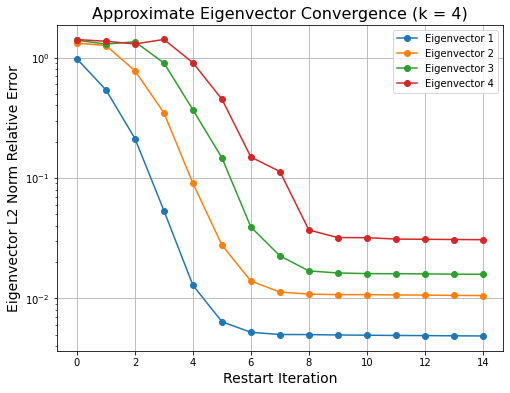

In [84]:

# Plot the eigenvector convergence
plt.figure(figsize=(8,6))

for i in range(k_val):
    # Loop over all the eigenvalues
    
    plt.semilogy(eig_vecs_conv_rel_err[i,:], marker='o', label="Eigenvector %d" % (i+1))

plt.xlabel("Restart Iteration", fontsize=14)
plt.ylabel("Eigenvector L2 Norm Relative Error", fontsize=14)

plt.title("Approximate Eigenvector Convergence (k = %d)" % (k_val), fontsize=16)

plt.legend()

plt.grid()

#plt.savefig("Results/GMRES-E/eig_vec_conv_k4.pdf")
